In [2]:
import re, sys
import pandas as pd
import matplotlib.pyplot as plt

from dGbyG.Chemistry.Reaction import Reaction
from dGbyG.utils.func import *
from dGbyG.utils.constants import *

In [3]:
tecrdb = pd.read_csv('./data/experimental_dG_from_eQ/TECRDB.csv')
formation_dg = pd.read_csv('./data/experimental_dG_from_eQ/formation_energies_transformed.csv')
redox = pd.read_csv('./data/experimental_dG_from_eQ/redox.csv')

data={'COCOM00012': 'CC(=O)C1=C[N+](=CC=C1)C1OC(COP([O-])(=O)OP([O-])(=O)OCC2OC(C(O)C2O)N2C=NC3=C(N)N=CN=C23)C(O)C1O',
      'COCOM00013': 'CC(=O)C1=CN(C=CC1)C1OC(COP([O-])(=O)OP([O-])(=O)OCC2OC(C(O)C2O)N2C=NC3=C(N)N=CN=C23)C(O)C1O'}
equilibrator_df = pd.DataFrame(data=data.items(), columns=['id', 'Smiles'], ).set_index(keys='id')

In [4]:
tecrdb_copy = tecrdb.loc[:,['description', 'reaction', 'K_prime', 'temperature', 'ionic_strength', 'p_h', 'p_mg']].copy()

for i in tecrdb_copy.index:
    r = tecrdb_copy.loc[i,'reaction']
    reaction = parse_equation(r)
    rxn = {}
    for name, coeff in reaction.items():
        name = name.strip()
        if c := re.match(r'^kegg:(C\d{5})$', name):
            kegg_entry = c.group(1)
            mol = to_mol(kegg_entry, 'kegg')
        elif c := re.match(r'^metanetx.chemical:(.+)$', name):
            metanetx_id = c.group(1)
            mol = to_mol(metanetx_id, 'metanetx')
        elif c := re.match(r'COCO:(.+)$', name):
            equilibrator_id = c.group(1)
            smiles = equilibrator_df.loc[equilibrator_id, 'Smiles']
            mol = to_mol(smiles, 'Smiles')
        else:
            print(i)

        if not mol:
            rxn = pd.NA
            break
        smiles = Chem.MolToSmiles(mol)
        rxn[smiles] = coeff
    
    rxn = build_equation(rxn) if pd.notna(rxn) else pd.NA
    tecrdb_copy.loc[i,'reaction'] = rxn

C01644 is tRNA(Ile), which has no Molfile
C01644 is tRNA(Ile), which has no Molfile
C01644 is tRNA(Ile), which has no Molfile
C01644 is tRNA(Ile), which has no Molfile
C01644 is tRNA(Ile), which has no Molfile
C01644 is tRNA(Ile), which has no Molfile
C01644 is tRNA(Ile), which has no Molfile
C01644 is tRNA(Ile), which has no Molfile
C01644 is tRNA(Ile), which has no Molfile
C01644 is tRNA(Ile), which has no Molfile
C01644 is tRNA(Ile), which has no Molfile
C01644 is tRNA(Ile), which has no Molfile
C01644 is tRNA(Ile), which has no Molfile
C01644 is tRNA(Ile), which has no Molfile
C01644 is tRNA(Ile), which has no Molfile
C01644 is tRNA(Ile), which has no Molfile
C01644 is tRNA(Ile), which has no Molfile
C01644 is tRNA(Ile), which has no Molfile
C01650 is tRNA(Ser), which has no Molfile
C01650 is tRNA(Ser), which has no Molfile
C01650 is tRNA(Ser), which has no Molfile
C01650 is tRNA(Ser), which has no Molfile
C01650 is tRNA(Ser), which has no Molfile
C01650 is tRNA(Ser), which has no 

In [4]:
tecrdb_copy = tecrdb_copy.loc[pd.notna(tecrdb_copy.loc[:,['reaction', 'K_prime']]).all(axis=1),:]
tecrdb_copy = tecrdb_copy.rename(columns={'temperature':'T', 'ionic_strength':'I', 'p_h':'pH', 'p_mg':'pMg'})
nontrans_standard_dg_primes = [(-R * row.T * np.log(row.K_prime)) for row in tecrdb_copy.itertuples()]
tecrdb_copy = tecrdb_copy.assign(**{"nontrans_standard_dg_primes": nontrans_standard_dg_primes})

In [3]:
#tecrdb_copy.to_csv('./tecrdb_copy.csv', index=False)
tecrdb_copy = pd.read_csv('./tecrdb_copy.csv')

In [5]:
ddg_prime = np.array([])
for row in tecrdb_copy.itertuples():
    R = Reaction(row.reaction)
    R.cid_type = 'smiles'
    condition = {'T':row.T}
    condition['pH'] = row.pH if pd.notna(row.pH) else default_pH
    condition['I'] = row.I if pd.notna(row.I) else default_I
    condition['pMg'] = row.pMg if pd.notna(row.pMg) else default_pMg
    if R.can_be_transform:
        ddg_prime = np.append(ddg_prime, R.transform(condition, default_condition))
    else:
        ddg_prime = np.append(ddg_prime, np.nan)

(array([  2.,   0.,   1.,   1.,   0.,  68., 675., 100., 118.,   6.]),
 array([-10.27069604,  -8.63702544,  -7.00335484,  -5.36968424,
         -3.73601364,  -2.10234303,  -0.46867243,   1.16499817,
          2.79866877,   4.43233937,   6.06600997]),
 <BarContainer object of 10 artists>)

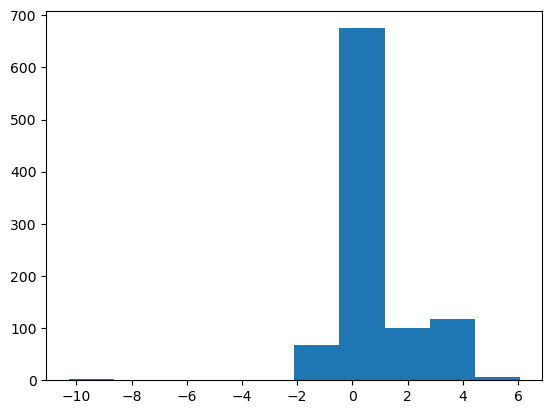

In [18]:
plt.hist(ddg_prime)

In [10]:
sum(np.isnan(ddg_prime))

2846

In [14]:
tecrdb_dedup = pd.DataFrame(index=range(len(set(tecrdb_copy.reaction))), columns=tecrdb_copy.columns)
i = 0

tecrdb_copy.index = tecrdb_copy.reaction
for r in set(tecrdb_copy.index):
    tecrdb_dedup.loc[i, 'reaction'] = r
    reaction = tecrdb_copy.loc[[r],:]
    if reaction.shape[0]==1:
        tecrdb_dedup.loc[i,:] = reaction.iloc[0,:]#.to_dict()
    else:
        tecrdb_dedup.loc[i,:] = reaction.iloc[0,:]#.to_dict()
    i += 1

In [15]:
S = equations_to_S(tecrdb_dedup.reaction)

In [16]:
tecrdb_dedup

,description,reaction,K_prime,T,I,pH,pMg,nontrans_standard_dg_primes
0,D-fructose 1-phosphate(aq) + H2O(l) = D-fructo...,[H]OC([H])([H])[C@@]1([H])OC(O[H])(C([H])([H])...,53.0,311.15,NaN,8.5,NaN,-10.265811
1,ATP(aq) + creatine(aq) = ADP(aq) + phosphocrea...,[H]O[C@@]1([H])[C@@]([H])(O[H])[C@]([H])(n2c([...,0.0054,310.15,NaN,7.0,NaN,13.457244
2,"D-glucose(aq) + NADP(aq) = D-glucono-1,5-lacto...",[H]OC1([H])O[C@]([H])(C([H])([H])O[H])[C@@]([H...,0.297,303.15,NaN,6.13,NaN,3.058339
3,N-acetyl-D-glucosamine 1-phosphate(aq) = N-ace...,[H]OC([H])([H])[C@@]1([H])OC([H])(OP(=O)(O[H])...,6.0,310.15,NaN,7.7,NaN,-4.617985
4,L-rhamnulose 1-phosphate(aq) = glycerone phosp...,[H]O[C@]([H])([C@@]([H])(O[H])C(=O)C([H])([H])...,0.083,310.15,NaN,7.5,NaN,6.414796
...,...,...,...,...,...,...,...,...
451,"5,10-methylenetetrahydrofolate(aq) + NAD(aq) =...",[H]OC(=O)C([H])([H])C([H])([H])C([H])(C(=O)O[H...,0.0096,310.15,NaN,7.9,NaN,11.974332
452,uridine(aq) + orthophosphate(aq) = uracil(aq) ...,[H]OC([H])([H])[C@@]1([H])O[C@@]([H])(n2c([H])...,0.078,310.15,NaN,8.2,NaN,6.574931
453,ATP(aq) + taurocyamine(aq) = ADP(aq) + N-w-pho...,[H]O[C@@]1([H])[C@@]([H])(O[H])[C@]([H])(n2c([...,29.0,308.15,NaN,7.25,NaN,-8.622724
454,ATP(aq) + dTMP(aq) = ADP(aq) + dTDP(aq),[H]O[C@@]1([H])[C@@]([H])(O[H])[C@]([H])(n2c([...,1.4,310.15,NaN,7.4,NaN,-0.867206
